# Predictive Modeling 
One of the critical uses of data recorded in the past is to attempt to make inferences about the future. Making predictions about future events on time series data can be done by forming a model on historical data.

An introductory example of the general methodology of data-driven predictions using partitioning data into; training, validation and testing sections is explored. These sections are used as follows; the data is used to derive a model from the training data. Next, this model is tested on available validation data. Finally, the model is applied to the testing data to predict its behaviour. 

A straightforward example of predictive modelling using linear regression is taken from the previous section and walked through. The question is to test if there is an observable drop-in $\textrm{CO}_2$ from the pandemic. In the previous section, a model was derived using least-squares regression and Fourier series of the form eq.{eq}`model`. In this example, the free co-efficient of the model will be discerned from the period from 1980 up to 2018. This period gives a large window to learn from to avoid lacking generalisation while also providing a good fit with the validation window of $2018, 2019$. 

When performing any supervised prediction task, a training data set is selected. A training set is data in which the independent and dependent variables are known. In such an example, the form of the predicted quantity is slightly obscured, ie the occurrence of an anomaly. However, the modelling of $\textrm{CO}_2$ concentration, $\textrm{CO}_2$ concentration and time are the dependent and independent variables, respectively. The model is then built from this data. For linear regression, this constitutes determining the form of the function and evaluating the free coefficients.

Using this model, the validation data is then investigated. This must not overlap with the training data. In the global $\textrm{CO}_2$ data, using the years $2018, 2019$ provides a period as similar as possible to the test window $2020, 2021$ asides from the pandemic anomaly being tested for. The quality of the model is then assessed on the validation data. Because the actual value of the validation data is known(There were no pandemics), the model's efficacy can be assessed here using the $\chi^2$ metric. 

If the model's behaviour on the validation set is satisfactory. Then the model can be used to investigate the test case. If there was a significant deviation from eq.{eq}`model` in 2020, then the presence of the pandemic can be shown. 



In [14]:
import pandas as pd
import scipy.optimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dur_utils import colours
from scipy import stats
from matplotlib import cycler
import matplotlib as mpl
import inspect
mpl.style.use('../matplotlibrc')

path_ml =  'https://gml.noaa.gov/webdata/ccgg/trends/co2/co2_mm_mlo.csv'              
co2_data_ml = pd.read_csv(path_ml, header=0, comment='#')
co2_data_ml = co2_data_ml[co2_data_ml['sdev']>0] 

In [15]:
def model(x, a_0, a_1, omega_0, omega_1, c, p_1,p_2,p_3):
    polynomial = x*p_1 + x**2*p_2 +x**3*p_3
    trig = a_0*np.cos((x + 1/2)*2*np.pi*omega_0) \
        + a_1*np.cos((x + 1/2)*2*np.pi*omega_1)
    return c + trig + polynomial

# Training Set
test_years = [i for i in range(1980, 2020)]
mask = np.isin(co2_data_ml['year'], test_years)
train_co2_data = co2_data_ml.iloc[mask]
# Validation Set
val_years = [i for i in range(2018, 2020)]
mask = np.isin(co2_data_ml['year'], val_years)
val_co2_data = co2_data_ml.iloc[mask]
# Test Set
test_years = [i for i in range(2020, 2021)]
mask = np.isin(co2_data_ml['year'], test_years)
test_co2_data = co2_data_ml.iloc[mask]
# Fitting
model_fit, model_error = scipy.optimize.curve_fit(model,
    co2_data_ml['decimal date'],
    co2_data_ml['average'],
    sigma = co2_data_ml['sdev'],
    p0=[5,5,1,2,-2*10**6,3*10**3,0,0] # Inital Parameter Guess
    )
#chisq
model_ml = model(co2_data_ml['decimal date'], *model_fit)
model_residuals = model_ml - co2_data_ml['average']
chisq_model = np.sum((model_residuals
    / co2_data_ml['sdev'])**2
    )
nu_model = co2_data_ml['average'].shape[0] - len(model_fit)
p_model = stats.chi2.sf(chisq_model,nu_model)
chi_crit = stats.chi2.isf(.05,nu_model)


```{margin} Classes
[Classes](https://docs.python.org/3/tutorial/classes.html) are the staple of Object oriented programming(OOP). An example is the `FittedModel` class. A class can be called and has methods and atributes. Methods are functions of the object. Atributes are values stored inside the class. A good example of a class is a list. It has multiple functions like `__len__()` which returns the instance of the classes length. The ` __init__()` dunder method initialises the class, creating an instance. The instance here is the specific object, a list of `[1, 2, 3]`.  The atributes of the list are its values. When implementing a class it is considered good practice to only have users interact with methods. Chapter 10 of [Python Programming: An introduction to Computer Science](https://www.google.co.uk/books/edition/Python_Programming/) covers Classes well. However, there are many guides online to their implementation. 
```

In [37]:
class FittedModel:
    def __init__(self, fn, x, y, sigma=None,
        p0=None, name=None, fit_coefs=None
        ):
        self.fn  = fn
        self.x = x
        self.y = y
        self.sigma = sigma
        self.p0 = p0
        self.name = name
        if fit_coefs:
            self.fit_coefs, self.fit_errs = fit_coefs
            self.fit_errs = None 
        else:
            self.fit_coefs , self.fit_cov = self.get_fit()
            self.fit_errs = np.diagonal(self.fit_cov)**0.5
    
    def get_fit(self):
        '''Applies scipy.optimize.curve_fit() to the passed args.

        returns fit_coefs array, correlation_array  
        '''
        model_fit, model_error = scipy.optimize.curve_fit(self.fn,
            self.x,
            self.y,
            sigma=self.sigma,
            p0=self.p0
            )
        return model_fit, model_error
    
    def fit_data(self):
        '''Returns the fitted function evaluated on x'''
        return self.fn(self.x, *self.fit_coefs)
    
    def get_chi2(self)-> int:
        '''Returns the chi^2 value of the model'''
        fit = self.fit_data()
        residuals = fit - self.y
        if self.sigma is not None:
            chi2 = np.sum((residuals / self.sigma)**2)
        else:
            print('No Uncertanity, Using Expectation')
            print('Expectation of the values is: E(residuals)') 
            chi2 = np.sum((residuals / np.mean(residuals))**2)
        return chi2

    def get_nu(self)-> int:
        '''Returns the degrees of freedom of the model'''
        return len(self.x) - len(self.fit_coefs)
    
    def get_sf(self) -> int:
        '''Returns P(chi^2 > chi^2_min)'''
        chi_min = self.get_chi2()
        nu = self.get_nu()
        return scipy.stats.chi2.sf(chi_min, nu)
    
    def print_errors(self):
        'Prints the models co-efficient\'s associated errors '
        coef_names = inspect.getfullargspec(self.fn).args
        for i, (value, error) in enumerate(zip(self.fit_coefs,self.fit_errs)):
            if error:
                print(f'{coef_names[1+i]} = {value:.2} +_ {error:.1}')
            else:
                print('No error. The model was fitted on other Data')

In [38]:
train  = FittedModel(model,
    train_co2_data['decimal date'],
    train_co2_data['average'],
    sigma=train_co2_data['sdev'],
    p0=[5,5,1,2,0,0,0,0],
    name = 'Training Model'
    )
test  = FittedModel(model,
    test_co2_data['decimal date'],
    test_co2_data['average'],
    sigma=test_co2_data['sdev'],
    name = 'Test Model', 
    fit_coefs= train.get_fit()
    )
val  = FittedModel(model,
    val_co2_data['decimal date'],
    val_co2_data['average'],
    sigma=val_co2_data['sdev'],
    name = 'Validation Model',
    fit_coefs= train.get_fit()
    )

print('Training Model Co-efficients')
train.print_errors()

Training Model Co-efficients
a_0 = 2.9 +_ 0.04
a_1 = 0.82 +_ 0.04
omega_0 = 1.0 +_ 1e-06
omega_1 = 2.0 +_ 4e-06
c = -2e+06 +_ 2e+05
p_1 = 3.1e+03 +_ 3e+02
p_2 = -1.5 +_ 0.1
p_3 = 0.00026 +_ 2e-05


### Problems with error on $P_0$ and $P_1$
The error on both quantities is astronomically high, around 10%. Further, it can be shown that it is an inaccurate measurement. If one changes the starting position for these quantities, the `p0` `kwarg` for `scipy.optimize.curve_fit`, the results do not oscillate around the obtained values indicating that the distribution of possible values is much tighter than the actual result. A better estimate of such errors can be determined by performing the fit with random start values centered around the obtained value.  


In [30]:
c_mean, p_mean = train.fit_coefs[[4,5]]
length = 1000
coef_df = pd.DataFrame(np.zeros((length, 2)), columns=['c', 'p_1'])
for i, _ in enumerate(coef_df):
    c_0 = np.random.normal(loc=c_mean, scale=abs(c_mean/10))
    p_1_0 = np.random.normal(loc=p_mean, scale=abs(p_mean/10))
    error_train  = FittedModel(model,
    train_co2_data['decimal date'],
    train_co2_data['average'],
    sigma=train_co2_data['sdev'],
    p0=[5,5,1,2,c_0,p_1_0,0,0],
    name = 'Training Model'
    )
    coef_df.iloc[:,] = error_train.fit_coefs[[4,5]]
coef_mean = np.mean(coef_df, axis=0)
coef_ste = np.std(coef_df, axis=0)
print(f'C coefficent:{coef_mean[0]:.2} +_ {coef_ste[0]:.1} \n'
    F'P_1 coefficient:{coef_mean[1]:.2} +_ {coef_ste[1]:.1}')
train.fit_errs[[4,5]] = coef_ste

C coefficent:-1.9e+06 +_ 2e-08 
P_1 coefficient:2.8e+03 +_ 4e-11


In [31]:
#params
labels = ['a_0', 'a_1', 'omega_0', 'omega_1', 'c', 'p_1', 'p_2', 'p_3']
model_fit_params = pd.Series(train.fit_coefs,index=labels)
fname = '../output_files/co2_model_parameters.csv'
model_fit_params.to_csv(fname)
#errors
model_cov_frame = pd.Series(train.fit_errs, index=labels)
fname = '../output_files/co2_model_parameters_errors.csv'

model_cov_frame.to_csv(fname)

In [32]:
for model_ in [train, val, test]:
    print(model_.name)
    print(f'chi^2 = {model_.get_chi2():.4}')
    print(f'chi^2/nu = {model_.get_chi2()/model_.get_nu():.4}')
    print(f'P(chi^2 > chi^2_min) = {model_.get_sf():.4}')
    print('')

Training Model
chi^2 = 1.005e+03
chi^2/nu = 2.134
P(chi^2 > chi^2_min) = 7.967e-41

Validation Model
chi^2 = 13.64
chi^2/nu = 0.8522
P(chi^2 > chi^2_min) = 0.6259

Test Model
chi^2 = 9.24
chi^2/nu = 2.31
P(chi^2 > chi^2_min) = 0.05537



## Results
The output $\chi^2$ statistics for the training model are to be desired, with a very low probability that the model demonstrates a good fit. However, This is not particularly important for the current test. Inspecting the performance of the model on the validation period, the model provides a good fit. This is exemplified by the $P(\chi^2 \geq \chi^2_{min};\nu) = 0.63$, well inside a significance level of 5 percent. This strong agreement between the validation data and the model suggests that the model is extended into the testing regime. 

In the testing regime, the $P(\chi^2 \geq \chi^2_{min};\nu) = 0.055$. This $P$ value indicates that approximately 5% of the time, the random variable normalised residuals would be distributed in such a manner. This extrapolation is pushing the bounds of the model. In this case, there is insufficient evidence to say that there has been a noticeable downwards trend in $\textrm{CO}_2$ production over the year $2020$. 

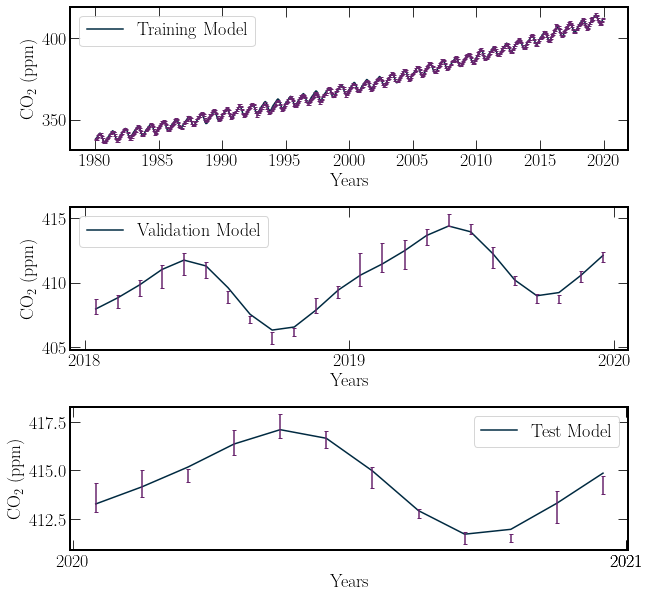

In [34]:
fig, ax  = plt.subplots(3,1, figsize = (10,10))
fig.subplots_adjust(hspace=0.4)
dur_cycle = cycler(color =[colours.durham.ink, colours.durham.purple,
    colours.durham.red]
    )

for i, model_ in enumerate([train, val, test]):
    #Formatting
    
    ax[i].set_xlabel('Years')
    ax[i].set_ylabel(r'$\textrm{CO}_2$ (ppm)')
    ax[i].set_prop_cycle(dur_cycle)
    #Data
    ax[i].plot(model_.x, model_.fit_data(), label = model_.name)
    ax[i].errorbar(model_.x, model_.y, model_.sigma, linestyle = '')
    ax[i].legend()
ax[1].set_xticks([2018, 2019, 2020])
ax[2].set_xticks([2020,2021,2021]);


## Discussion

The linear-regression model developed in the previous section does not account for any global effects that vary the average behaviour of the $\textrm{CO}_2$ concentration in the previous section. When using the $\chi^2$ statistic, this returns very poor fits over many years due to significant variances, exemplified by the 90s. However, a small window representing the general overall trend without high variance, like the period of 2018 and 2019, can present a good fit. Towards the end of the year 2021, the residuals of the data points are all negative. This could be the presence of Covid-19; however, the residuals are similar in size to the uncertainty, resulting in the high $\chi^2$ value. 

More can be read about using the $\textrm{CO}_2$ concentration in the atmosphere to detect the [pandemic](https://gml.noaa.gov/ccgg/covid2.html). 
```{note}
The TLDR of the article from the NOAA, is that global $\textrm{CO}_2$ concentrations are buffered by release from the ocean and that fires in the southern hemisphere, could have offset the $\textrm{CO}_2$ emission decrease. 
```
